# Detect Pneumonia Using X-Ray Images with CNN (ResNet50 model)

## 1. Imports and Paths

In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


## 2. Define dataset paths & constants

In [ ]:
# Base data directory
DATA_DIR = "data/chest_xray_reorganized"

TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "val")
TEST_DIR  = os.path.join(DATA_DIR, "test")

## 3. Data exploration

In [4]:
# verify counts and class distribution.
def count_images(directory):
    counts = {}
    for label in os.listdir(directory):
        label_path = os.path.join(directory, label)
        if os.path.isdir(label_path):
            counts[label] = len(os.listdir(label_path))
    return counts

print("Train:", count_images(TRAIN_DIR))
print("Validation:", count_images(VAL_DIR))
print("Test:", count_images(TEST_DIR))

Train: {'PNEUMONIA': 3418, 'NORMAL': 1266}
Validation: {'PNEUMONIA': 427, 'NORMAL': 158}
Test: {'PNEUMONIA': 428, 'NORMAL': 159}


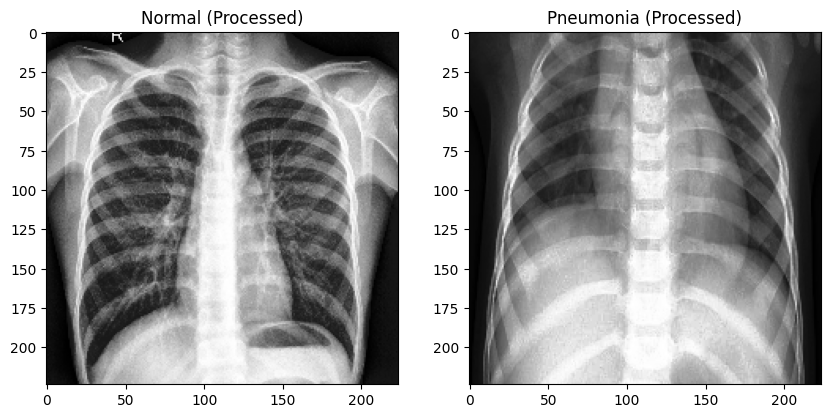

In [6]:
# Visualize a "normal" vs "pneumonia" lung
import cv2
import matplotlib.pyplot as plt
import os

# Paths to two example images
normal_sample = 'data/chest_xray_reorganized/train/NORMAL/IM-0007-0001.jpeg'
pneumonia_sample = 'data/chest_xray_reorganized/train/PNEUMONIA/person1_bacteria_1.jpeg'

def process_and_show(path, title):
    # 1. Load with OpenCV
    img = cv2.imread(path)
    
    # 2. Grayscale (Makes sense: Reduces noise/complexity)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 3. Resize (Makes sense: Required for the CNN input)
    resized = cv2.resize(gray, (224, 224))
    
    # 4. Histogram Equalization (Helps see the fluid/infection better)
    equalized = cv2.equalizeHist(resized)
    
    return equalized

# Display them
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(process_and_show(normal_sample, ""), cmap='gray')
plt.title("Normal (Processed)")

plt.subplot(1, 2, 2)
plt.imshow(process_and_show(pneumonia_sample, ""), cmap='gray')
plt.title("Pneumonia (Processed)")
plt.show()

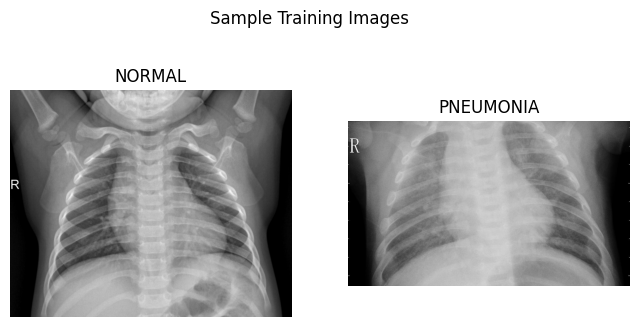

In [7]:
# Visualize sample X-ray images
def show_sample_images(directory, title):
    plt.figure(figsize=(8, 4))
    classes = ["NORMAL", "PNEUMONIA"]
    
    for i, cls in enumerate(classes):
        cls_path = os.path.join(directory, cls)
        img_name = np.random.choice(os.listdir(cls_path))
        img_path = os.path.join(cls_path, img_name)
        
        img = plt.imread(img_path)
        
        plt.subplot(1, 2, i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(cls)
        plt.axis("off")
    
    plt.suptitle(title)
    plt.show()

show_sample_images(TRAIN_DIR, "Sample Training Images")


## 4. Image Preprocessing (ResNet-specific)

General Preprocessing steps:
1. Grayscale conversion: dropping color channels reduces the data the CNN has to process by 3x 
without losing info (not applicable to all models, some models like MobileNetV2 were trained on RGB images with three channels)
1. Resizing: CNNs require every input image to be the exact same size (e.g., 224×224)
2. Normalization: Dividing pixel values by 255 (changing range from 0–255 to 0.0–1.0) helps the model learn faster and more stably
3. Data Augmentation (Rotation/Flipping): prevents the model from memorizing specific images. Data augmentation is not applied here due to the nature of X-ray images.

ResNet50 expects images preprocessed in a specific way.

In [9]:
from tensorflow.keras.applications.resnet50 import preprocess_input

# define parameters
IMG_SIZE = (224, 224)   # Required by ResNet50
BATCH_SIZE = 32

### Load datasets into Image generators 

In [10]:
"""ImageDataGenerator loads images from disk, preprocesses them, and feeds them to the model in batches.
preprocess_input is  model-specific preprocessing. For ResNet50, it:
-converts RGB → BGR, 
-subtracts ImageNet mean pixel values,
-scales pixels appropriately. 
Why this matters:
ResNet50 was trained on ImageNet with this exact preprocessing"""

train_gen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_gen   = ImageDataGenerator(preprocessing_function=preprocess_input)
test_gen  = ImageDataGenerator(preprocessing_function=preprocess_input)

In [11]:
# Load data:
train_data = train_gen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

val_data = val_gen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

test_data = test_gen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

Found 4684 images belonging to 2 classes.
Found 585 images belonging to 2 classes.
Found 587 images belonging to 2 classes.


## 6. Transfer Learning with Resnet50 model
Steps: 
1. Use ResNet50 as a feature extractor
2. Freeze its pretrained layers
3. Add a small custom classifier head
4. Train it on the pneumonia dataset
5. Evaluate performance properly
   
Because:    
X-ray datasets are relatively small.  
Training ResNet from scratch would overfit badly.  
ResNet has already learned generic visual features. 

ResNet50 was trained on ImageNet (natural images):    
-Early layers learn edges, blobs, textures.  
-Middle layers learn shapes & patterns.  
-These features transfer well to medical images.  

The only thing ResNet doesn’t know is:   
“What does pneumonia look like?”   
That’s what our classifier head will learn.

### 6.1 Load pretrained ResNet50 without its classifier

In [12]:

base_model = ResNet50(
    weights="imagenet",
    include_top=False,  # because the original classifier predicts 1000 ImageNet classes and we will build our own
    input_shape=(224, 224, 3)
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


### 6.2 Freeze the pretrained layers

In [13]:
# Speeds up training and avoids overfitting
for layer in base_model.layers:
    layer.trainable = False

### 6.3 Add a custom classification head

In [14]:
x = base_model.output
x = GlobalAveragePooling2D()(x)             # reduces spatial dimensions safely
x = Dense(128, activation="relu")(x)        # learns pneumonia-specific features
x = Dropout(0.5)(x)                         # regularization
output = Dense(1, activation="sigmoid")(x)  # binary classification 

### 6.4 Final model

In [15]:
model = Model(inputs=base_model.input, outputs=output)

# inspect it
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

### 6.5 Compile the model

In [16]:
# low learning rate because we’re training only the head and small updates are safer

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

### 6.6 Train the model

In [17]:
# Add early stopping
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

# train
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stop]
)


Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 69s 449ms/step - accuracy: 0.8930 - loss: 0.2576 - val_accuracy: 0.9248 - val_loss: 0.1873
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 66s 450ms/step - accuracy: 0.9383 - loss: 0.1551 - val_accuracy: 0.9436 - val_loss: 0.1589
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 67s 457ms/step - accuracy: 0.9500 - loss: 0.1312 - val_accuracy: 0.9436 - val_loss: 0.1450
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 68s 464ms/step - accuracy: 0.9575 - loss: 0.1181 - val_accuracy: 0.9385 - val_loss: 0.1447
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 69s 467ms/step - accuracy: 0.9599 - loss: 0.1059 - val_accuracy: 0.9504 - val_loss: 0.1333
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 70s 478ms/step - accuracy: 0.9603 - loss: 0.1029 - val_accuracy: 0.9385 - val_loss: 0.1536
Epoch 7/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 70s 476ms/step - accuracy: 0.9686 - loss: 0.0982 - val_accuracy: 0.9453 - val_loss: 0.1244
Epoch 8/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 70s 479ms/step - accuracy: 0.9667 - loss: 0

## 7. Visualize training results

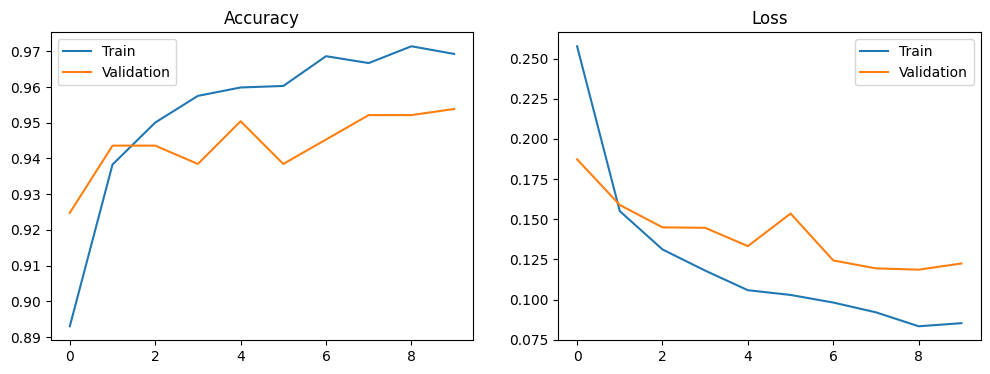

In [18]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Validation")
plt.title("Loss")
plt.legend()

plt.show()


High training accuracy - validation accuracy plateaus earlier

## 8. Evaluate on test set

In [19]:
test_preds = model.predict(test_data)
test_preds = (test_preds > 0.5).astype(int).ravel()

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 441ms/step


#### Confusion matrix

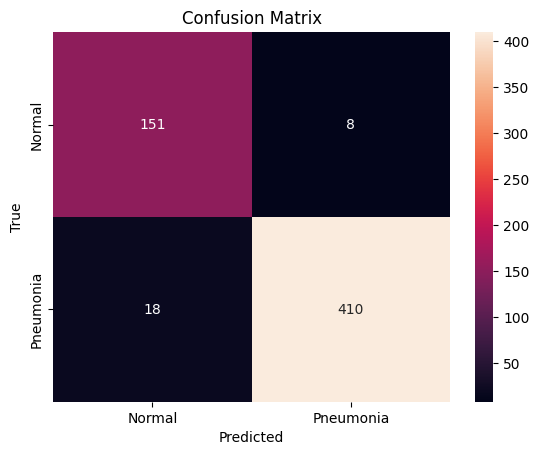

In [20]:
cm = confusion_matrix(test_data.classes, test_preds)

sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=["Normal", "Pneumonia"],
            yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


#### Classification report

In [21]:
print(classification_report(
    test_data.classes,
    test_preds,
    target_names=["Normal", "Pneumonia"]
))


              precision    recall  f1-score   support

      Normal       0.89      0.95      0.92       159
   Pneumonia       0.98      0.96      0.97       428

    accuracy                           0.96       587
   macro avg       0.94      0.95      0.94       587
weighted avg       0.96      0.96      0.96       587



## 9. Fine-Tune The Model
#### Training vs validation during baseline training:     

Training accuracy rises steadily:    
~0.89 → ~0.97.   
Training loss keeps decreasing:   
~0.25 → ~0.08.   
Validation accuracy:    
plateaus around 0.94–0.95.  
Validation loss:   
fluctuates and slightly increases after some epochs.  

**Interpretation**:     
This is mild to moderate overfitting, not catastrophic overfitting.

* Validation accuracy is still high.   
* Validation loss does not explode
* Generalization to test set is strong
* So the model is:   
learning meaningful features, but starting to memorize training-specific patterns.

#### Test set performance 
From the confusion matrix:
|                    | Pred Normal | Pred Pneumonia |
| ------------------ | ----------- | -------------- |
| **True Normal**    | 151         | 8              |
| **True Pneumonia** | 18          | 410            |

**Key observations**:
- False negatives (missed pneumonia): 18
- False positives: 8

**Classification report**:
- Pneumonia recall: 0.96  (Recall: measures the ability to find all actual positives (\(TP/(TP+FN)\))
- Overall accuracy: 0.96. 
This confirms:    
The model generalizes well, despite training-validation divergence.



#### Fine-tuning strategy

The current model:
- uses ResNet50 as a frozen feature extractor and trained only a small classifier head
- has learned a strong but slightly rigid decision boundary.  
  
Fine-tuning helps when:   
- The model under-adapts to domain-specific features.
- High-level ImageNet features don’t perfectly match X-ray patterns.
  
We will allow the top layers of ResNet50 to slightly adapt to X-ray features. We do not retrain the whole network because that would destroy pretrained knowledge, overfit immediately and be computationally expensive.

Why only top layers? Because the ResNet50 structure looks like this:
Bottom layers → edges, gradients, textures (very generic)
Top layers → task-specific patterns (can adapt)
For medical images edges stay edges and higher-level textures differ from natural images.

### Step 1 - Unfreeze top ResNet layers
This model is already strong so we don’t want drastic changes. Unfreezing only the top layers lets the model refine lung-specific textures
and adjust to grayscale-like medical patterns.  

Important nuance:  
We should not unfreeze too many layers, 20–30 layers is appropriate given our results.

In [22]:
# Unfreeze the top 30 layers of ResNet50
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Keep the rest frozen
for layer in base_model.layers[:-30]:
    layer.trainable = False

# We selectively unfreeze only the deepest layers to allow limited task-specific adaptation while preserving general visual features learned from ImageNet.

### Step 2 - Recompile with a lower learning rate
Recompiling is critical, otherwise fine-tuning does nothing.
Why  lower LR? Because pretrained weights are already good, large updates would destroy them and we want small, careful adjustments.
A lower learning rate is used during fine-tuning to avoid catastrophic forgetting and ensure stable gradient updates.

A lower learning rate allowed the model to slightly adjust pretrained filters to X-ray features

In [23]:
# recompile
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

### Step 3 - Fine-tune the model

In [24]:
# continue training from the previous state
# early stopping is still important here
fine_tune_history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=10,
    callbacks=[early_stop]
)

Epoch 1/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 108s 700ms/step - accuracy: 0.9541 - loss: 0.1259 - val_accuracy: 0.9624 - val_loss: 0.1088
Epoch 2/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 104s 704ms/step - accuracy: 0.9855 - loss: 0.0543 - val_accuracy: 0.9590 - val_loss: 0.1036
Epoch 3/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 106s 720ms/step - accuracy: 0.9898 - loss: 0.0341 - val_accuracy: 0.9675 - val_loss: 0.1019
Epoch 4/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 107s 729ms/step - accuracy: 0.9957 - loss: 0.0191 - val_accuracy: 0.9641 - val_loss: 0.1095
Epoch 5/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 109s 739ms/step - accuracy: 0.9977 - loss: 0.0121 - val_accuracy: 0.9692 - val_loss: 0.1068
Epoch 6/10
147/147 ━━━━━━━━━━━━━━━━━━━━ 109s 741ms/step - accuracy: 0.9987 - loss: 0.0087 - val_accuracy: 0.9726 - val_loss: 0.1103


**Observations**

EarlyStopping was applied here. Early stopping typically monitors validation loss (val_loss) and stops training when:
validation performance stops improving for ````patience```` consecutive epochs.

What we see in the logs: training loss keeps decreasing sharply.   

Validation loss improves slightly at first, then plateaus and fluctuates and does not meaningfully decrease further.   

At epoch ~6: no real validation improvement - Risk of overfitting increases. 
-> Training stopped early to prevent memorization of training data

**Result**

Training accuracy → ~99.9%. 

Validation accuracy → ~97.2%.   

Validation loss → stable but not decreasing further.  
This means the model learned everything it reasonably could from the dataset without overfitting too badly.

### Step 4 — Compare training curves (before vs after)

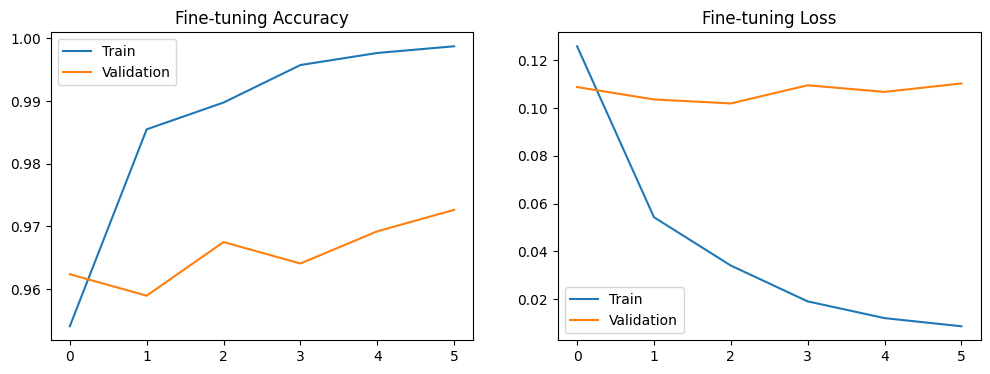

In [25]:
# Plot fine-tuning results
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(fine_tune_history.history["accuracy"], label="Train")
plt.plot(fine_tune_history.history["val_accuracy"], label="Validation")
plt.title("Fine-tuning Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(fine_tune_history.history["loss"], label="Train")
plt.plot(fine_tune_history.history["val_loss"], label="Validation")
plt.title("Fine-tuning Loss")
plt.legend()

plt.show()


**Interpreting the curves**.  
* Accuracy plot:  
Training accuracy → keeps increasing → almost perfect.    
Validation accuracy → improves modestly, then stabilizes.  
Interpretation:    
The model fits training data extremely well. Generalization is strong but not perfect.  
Small train–val gap → mild overfitting, acceptable in this context

* Loss plot:     
Training loss → drops rapidly toward zero.   
Validation loss → flattens and slightly oscillates.  
Interpretation:   
The model becomes more confident on training samples, but confidence on unseen data does not improve further.  
Further training would increase overfitting, not performance.

### Step 5 — Evaluate the fine-tuned model

In [26]:
fine_preds = model.predict(test_data)
fine_preds = (fine_preds > 0.5).astype(int).ravel()

19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 417ms/step


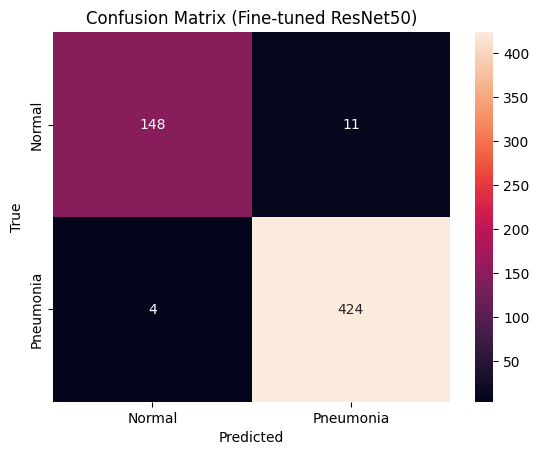

In [27]:
# Confusion matrix
cm_fine = confusion_matrix(test_data.classes, fine_preds)

sns.heatmap(
    cm_fine,
    annot=True,
    fmt="d",
    xticklabels=["Normal", "Pneumonia"],
    yticklabels=["Normal", "Pneumonia"]
)
plt.title("Confusion Matrix (Fine-tuned ResNet50)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

**Key numbers**

True Positives (TP) = 424
False Negatives (FN) = 4
False Positives (FP) = 11
True Negatives (TN) = 148

Pneumonia Recall (Sensitivity): Of all pneumonia patients, 99.1% were catched by the model.    

Recall = TP / TP + FN = 424 / 424 + 4 ≈ 99.1%.  
Only 4 pneumonia cases were missed. (FN)


In [28]:
# Classification report
print(classification_report(
    test_data.classes,
    fine_preds,
    target_names=["Normal", "Pneumonia"]
))

              precision    recall  f1-score   support

      Normal       0.97      0.93      0.95       159
   Pneumonia       0.97      0.99      0.98       428

    accuracy                           0.97       587
   macro avg       0.97      0.96      0.97       587
weighted avg       0.97      0.97      0.97       587



### Step 6 -  Metrics comparison
What to compare:
Accuracy
Recall (especially for Pneumonia)
False negatives (Very important in pneumonia detection, false negatives are more critical than false positives, since missing a disease is riskier than over-flagging a healthy patient.)

### Step 7 - Overfitting vs Underfitting
Underfitting occurs when the model is too simple to capture the underlying data patterns, resulting in low performance on both training and validation sets.  

Overfitting occurs when the model learns noise or dataset-specific features, showing high training performance but degraded validation or test performance. 

In this project:   
Baseline ResNet (frozen) → risk of underfitting
Fine-tuned ResNet → better bias-variance balance
Early stopping + partial unfreezing → controlled overfitting

### Step 8 — Final summary

**Comparison: Baseline vs Fine-tuned ResNet50**
| Metric           | Baseline (frozen ResNet) | Fine-tuned ResNet            |
| ---------------- | ------------------------ | ---------------------------- |
| Accuracy         | Lower (~94–96%)          | **~97%+**                    |
| Pneumonia Recall | High but lower           | **~99.1%**                   |
| False Negatives  | Higher                   | **Reduced to 4**             |
| Overfitting      | Low                      | Slight but controlled        |
| Generalization   | Good                     | **Better feature alignment** |

**What fine-tuning improved**

* Better alignment of filters to medical X-ray textures
* Slight boost in validation accuracy
* Critical reduction in false negatives
* More confident pneumonia detection

What it did not improve:
* Validation loss did not drop significantly. 
* Indicates dataset-limited performance ceiling. 
This is normal and expected.


We first trained a ResNet50 model using transfer learning by freezing pretrained layers and training a custom classifier head. To improve performance, we fine-tuned the top layers of the network using a lower learning rate, allowing the model to adapt high-level features to chest X-ray data while preventing catastrophic forgetting.

Fine-tuning ResNet50 improved pneumonia detection performance, especially recall, while maintaining controlled overfitting through early stopping. The model achieves high sensitivity with very few false negatives, which is crucial in medical imaging applications.